# ※ 크롤링 프로그램


## 네이버 광고 API를 이용하여 월간검색량 구하기
: 원하는 검색어의 구합니다. 복수개의 검색어 입력가능합니다.

In [3]:
import requests
import hmac
import hashlib
import base64
import time
from datetime import datetime

# 네이버 API 관련 설정
API_KEY = "0100000000f7219646b1189747046631aa4d35e62954247e750a216e37f7072b5174cbe5c2"
SECRET_KEY = "AQAAAAD3IZZGsRiXRwRmMapNNeYpncLjvqyOrRpn2cZDTV49Ug=="
CUSTOMER_ID = "373124"

def generate_signature(timestamp, method, uri, secret_key):
    message = f"{timestamp}.{method}.{uri}"
    signature = hmac.new(secret_key.encode(), message.encode(), hashlib.sha256).digest()
    signature_b64 = base64.b64encode(signature).decode()
    return signature_b64

def get_naver_search_volume(api_key, secret_key, customer_id, keywords):
    result = {}
    for i in range(0, len(keywords), 5):  # 5개씩 묶음
        sub_keywords = keywords[i:i+5]
        timestamp = str(int(time.time() * 1000))
        method = "GET"
        uri = "/keywordstool"
        signature = generate_signature(timestamp, method, uri, secret_key)
        
        url = "https://api.naver.com" + uri
        headers = {
            "X-API-KEY": api_key,
            "X-CUSTOMER": customer_id,
            "X-Timestamp": timestamp,
            "X-Signature": signature,
            "Content-Type": "application/json",
            "Accept": "*/*"
        }
        params = {
            "hintKeywords": ",".join(sub_keywords),
            "showDetail": "1"
        }
        
        response = requests.get(url, headers=headers, params=params)
        
        if response.status_code == 200:
            data = response.json()
            for item in data.get("keywordList", []):
                keyword = item.get("relKeyword")
                if keyword in sub_keywords:  # 입력한 키워드만 결과에 포함
                    monthlyPcQcCnt = item.get("monthlyPcQcCnt", 0)
                    monthlyMobileQcCnt = item.get("monthlyMobileQcCnt", 0)
                    
                    if isinstance(monthlyPcQcCnt, str) and '<' in monthlyPcQcCnt:
                        monthlyPcQcCnt = 5  # '< 10'인 경우, 5로 설정 (임의 값)
                    else:
                        monthlyPcQcCnt = int(monthlyPcQcCnt)
                        
                    if isinstance(monthlyMobileQcCnt, str) and '<' in monthlyMobileQcCnt:
                        monthlyMobileQcCnt = 5  # '< 10'인 경우, 5로 설정 (임의 값)
                    else:
                        monthlyMobileQcCnt = int(monthlyMobileQcCnt)
                        
                    total_search_volume = monthlyPcQcCnt + monthlyMobileQcCnt
                    result[keyword] = {
                        "PC": monthlyPcQcCnt,
                        "Mobile": monthlyMobileQcCnt,
                        "Total": total_search_volume
                    }
        else:
            print(f"Error: {response.status_code}, {response.text}")
    return result

def main():
    keywords = []
    
    # 첫 번째 검색어는 필수 입력
    while True:
        keyword = input("검색어를 입력하세요 (필수): ").strip()
        if keyword:
            keywords.append(keyword)
            break
        else:
            print("검색어를 입력해야 합니다.")

    # 추가 검색어 입력 (옵션)
    while True:
        keyword = input("추가 검색어를 입력하세요 (입력 없이 Enter를 누르면 실행됩니다): ").strip()
        if keyword:
            keywords.append(keyword)
        else:
            break
    
    if keywords:
        print("\n검색을 시작합니다...")
        search_volumes = get_naver_search_volume(API_KEY, SECRET_KEY, CUSTOMER_ID, keywords)
        
        print("\n검색 결과:")
        for keyword in keywords:  # 입력한 검색어만 출력
            volumes = search_volumes.get(keyword, None)
            if volumes:
                print(f"검색어: {keyword}")
                print(f"  - 월간 PC 검색량: {volumes['PC']}")
                print(f"  - 월간 모바일 검색량: {volumes['Mobile']}")
                print(f"  - 월간 총 검색량: {volumes['Total']}")
                print("-" * 50)
            else:
                print(f"검색어: {keyword}에 대한 데이터를 찾을 수 없습니다.")
                print("-" * 50)

if __name__ == "__main__":
    main()


KeyboardInterrupt: Interrupted by user

## 네이버 데이터랩에서 검색어 추이 분석(검색어 최대 5개 입력받을 수 있음)

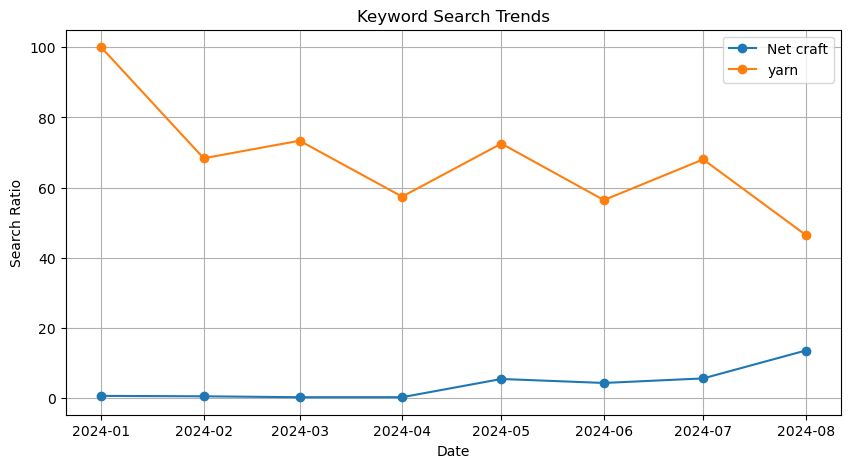

In [10]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from tkinter import simpledialog, Tk
from deep_translator import GoogleTranslator
import json

# 네이버 API 인증 정보
client_id = 'NM0_03gTtgRgamfzdgpM'  # 네이버 개발자 센터에서 발급받은 client_id 입력
client_secret = 'wVJP2iAT52'  # 네이버 개발자 센터에서 발급받은 client_secret 입력

# 사용자로부터 검색어 입력 받기 (최대 5개)
root = Tk()
root.withdraw()

search_keywords = []
for i in range(5):
    keyword = simpledialog.askstring("검색어 입력", f"검색어 {i+1}를 입력하세요 (입력을 중단하려면 빈 칸으로 두고 확인을 누르세요):")
    if keyword:
        search_keywords.append(keyword)
    else:
        break

if not search_keywords:
    print("검색어가 입력되지 않았습니다.")
    exit()

# 사용자로부터 시작 날짜와 종료 날짜 입력 받기
start_date = simpledialog.askstring("시작 날짜 입력", "검색 시작 날짜를 입력하세요 (형식: yyyymmdd):")
end_date = simpledialog.askstring("종료 날짜 입력", "검색 종료 날짜를 입력하세요 (형식: yyyymmdd):")

# 입력된 날짜 확인
if not start_date or not end_date:
    print("날짜가 입력되지 않았습니다.")
    exit()

# 날짜 형식 확인 및 변환
try:
    start_date = pd.to_datetime(start_date, format='%Y%m%d').strftime('%Y-%m-%d')
    end_date = pd.to_datetime(end_date, format='%Y%m%d').strftime('%Y-%m-%d')
except ValueError:
    print("날짜 형식이 잘못되었습니다. yyyymmdd 형식으로 입력해주세요.")
    exit()

# 번역기 초기화 및 검색어 번역
translated_keywords = [GoogleTranslator(source='auto', target='en').translate(keyword) for keyword in search_keywords]

# API 요청 URL 및 헤더 설정
url = 'https://openapi.naver.com/v1/datalab/search'
headers = {
    'X-Naver-Client-Id': client_id,
    'X-Naver-Client-Secret': client_secret,
    'Content-Type': 'application/json'
}

# 요청 데이터 설정
keyword_groups = [{"groupName": keyword, "keywords": [keyword]} for keyword in search_keywords]
data = {
    "startDate": start_date,
    "endDate": end_date,
    "timeUnit": "month",
    "keywordGroups": keyword_groups
}

# 요청 데이터 출력 (디버깅 목적)
# print("Request Data:")
# print(json.dumps(data, indent=4, ensure_ascii=False))

# API 요청
response = requests.post(url, headers=headers, json=data)

# 응답 데이터 확인 및 오류 출력
if response.status_code == 200:
    result = response.json()
elif response.status_code == 400:
    print("Error Code: 400 - Bad Request")
    print("Response Content:", response.content.decode('utf-8'))
    exit()
else:
    print("Error Code:", response.status_code)
    print("Response Content:", response.content.decode('utf-8'))
    exit()

# 데이터프레임으로 변환 및 시각화
plt.figure(figsize=(10, 5))

for keyword_group, translated_keyword in zip(result['results'], translated_keywords):
    df = pd.DataFrame(keyword_group['data'])
    df['period'] = pd.to_datetime(df['period'])
    df.set_index('period', inplace=True)
    plt.plot(df.index, df['ratio'], marker='o', linestyle='-', label=translated_keyword)

plt.title('Keyword Search Trends')
plt.xlabel('Date')
plt.ylabel('Search Ratio')
plt.legend()
plt.grid(True)
plt.show()


## 네이버 블로그 검색
: 네이버 블로그 검색 API를 사용하여 사용자가 입력한 키워드와 검색 결과 건수에 따라 블로그 게시물을 검색하고, 결과를 엑셀 파일로 저장한 후 파일을 자동실행

In [ ]:
import requests
import pandas as pd
import os
from datetime import datetime

# 환경 변수에서 네이버 API 정보 가져오기
client_id = os.getenv('NAVER_CLIENT_ID')
client_secret = os.getenv('NAVER_CLIENT_SECRET')

if not client_id or not client_secret:
    raise ValueError("NAVER_CLIENT_ID와 NAVER_CLIENT_SECRET 환경 변수를 설정해주세요.")

# 검색할 키워드와 출력 건수, 저장 파일명 입력 받기
keyword = input("검색할 키워드를 입력하세요: ")
display_count = input("출력할 검색 결과의 건수를 입력하세요 (1~100): ")
file_name = input("저장할 파일명을 입력하세요 (확장자 제외): ")

# 입력된 출력 건수 유효성 검사
try:
    display_count = int(display_count)
    if display_count < 1 or display_count > 100:
        raise ValueError
except ValueError:
    raise ValueError("출력 건수는 1에서 100 사이의 정수여야 합니다.")

# 네이버 블로그 검색 API URL
url = 'https://openapi.naver.com/v1/search/blog.json'

# 요청 헤더
headers = {
    'X-Naver-Client-Id': client_id,
    'X-Naver-Client-Secret': client_secret
}

# 요청 파라미터
params = {
    'query': keyword,
    'display': display_count,  # 검색 결과의 출력 건수
    'start': 1,                # 검색 시작 위치
    'sort': 'date'             # 정렬 옵션: date(날짜순), sim(유사도순)
}

# API 요청
response = requests.get(url, headers=headers, params=params)

# 응답 데이터 확인
if response.status_code == 200:
    result = response.json()
    items = result['items']
    
    # 결과를 저장할 리스트
    data = []
    
    for idx, item in enumerate(items, start=1):
        title = item['title']
        link = item['link']
        description = item['description']
        bloggername = item['bloggername']
        postdate = item['postdate']
        
        data.append({
            '순번': idx,
            '제목': title,
            'URL': link,
            '요약': description,
            '블로거 이름': bloggername,
            '포스트 날짜': postdate
        })
        
        # 화면에 출력
        print(f'순번: {idx}')
        print(f'제목: {title}')
        print(f'URL: {link}')
        print(f'요약: {description}')
        print(f'블로거 이름: {bloggername}')
        print(f'포스트 날짜: {postdate}')
        print('------')
    
    # 데이터프레임으로 변환
    df = pd.DataFrame(data)
    
    # 오늘 날짜를 yyyymmdd 형식으로 얻기
    today = datetime.today().strftime('%Y%m%d')
    
    # 엑셀 파일로 저장 (파일 이름에 경로 추가 및 날짜 접미사 추가)
    output_directory = os.path.expanduser("~")
    excel_filename = os.path.join(output_directory, f'{file_name}_{today}.xlsx')
    df.to_excel(excel_filename, index=False)
    
    print(f'검색 결과가 엑셀 파일로 저장되었습니다: {excel_filename}')
    
    # 엑셀 파일 열기
    os.system(f'start excel "{excel_filename}"')
else:
    print('API 요청에 실패했습니다. 상태 코드:', response.status_code)
    print('오류 메시지:', response.json())


## 네이버 쇼핑 검색 
: 댓글이 안나와서 판매량 예측 힘듦(네이버 API에서 제공 안함, 웹크롤링 검토해야 됨)


In [16]:
import os
import requests
import json
import datetime
import pandas as pd
import platform

def search_naver_shopping(query, display):
    """
    네이버 쇼핑 API를 사용하여 주어진 검색어(query)와 결과 개수(display)에 따라 상품을 검색합니다.
    
    Args:
    query (str): 검색어
    display (int): 검색 결과 개수
    
    Returns:
    list: 검색된 상품 목록
    """
    client_id = os.getenv('NAVER_CLIENT_ID')  # 네이버 API 클라이언트 ID
    client_secret = os.getenv('NAVER_CLIENT_SECRET')  # 네이버 API 클라이언트 시크릿
    
    url = f'https://openapi.naver.com/v1/search/shop.json?query={query}&display={display}'
    headers = {
        'X-Naver-Client-Id': client_id,
        'X-Naver-Client-Secret': client_secret
    }
    
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # HTTP 오류가 발생하면 예외를 발생시킴

        data = response.json()
        if 'items' in data:
            return data['items']
        else:
            print('응답에 "items" 키가 없습니다.')
            return []
    except requests.exceptions.HTTPError as http_err:
        print(f'HTTP 오류 발생: {http_err}')
    except requests.exceptions.ConnectionError as conn_err:
        print(f'연결 오류 발생: {conn_err}')
    except requests.exceptions.Timeout as timeout_err:
        print(f'타임아웃 오류 발생: {timeout_err}')
    except requests.exceptions.RequestException as req_err:
        print(f'요청 오류 발생: {req_err}')
    except json.JSONDecodeError as json_err:
        print(f'JSON 디코딩 오류 발생: {json_err}')
    except Exception as err:
        print(f'예상치 못한 오류 발생: {err}')

    return []

def save_results_to_file(items, filename):
    """
    검색된 상품 목록을 엑셀 파일로 저장하고 파일을 엽니다.
    
    Args:
    items (list): 검색된 상품 목록
    filename (str): 저장할 파일명 (확장자 없이)
    """
    today_date = datetime.datetime.now().strftime("%Y-%m-%d")
    full_filename = f"{filename}_{today_date}.xlsx"
    
    try:
        for i, item in enumerate(items, start=1):
            item['순번'] = i
            item['lprice'] = int(item['lprice']) if item['lprice'] else 0
            item['hprice'] = int(item['hprice']) if item['hprice'] else 0
        
        df = pd.DataFrame(items)
        
        cols = ['순번'] + [col for col in df.columns if col != '순번']
        df = df[cols]
        
        df.to_excel(full_filename, index=False)
        
        print(f"검색 결과가 파일 '{full_filename}'에 저장되었습니다.")
        
        # 저장한 파일 열기
        if platform.system() == 'Windows':
            os.startfile(full_filename)
        elif platform.system() == 'Darwin':  # macOS
            os.system(f'open "{full_filename}"')
        else:  # Linux variants
            os.system(f'xdg-open "{full_filename}"')
    except IOError as io_err:
        print(f'파일 쓰기 오류 발생: {io_err}')
    except Exception as err:
        print(f'예상치 못한 오류 발생: {err}')

def print_results(items):
    """
    검색된 상품 목록을 콘솔에 출력합니다.
    
    Args:
    items (list): 검색된 상품 목록
    """
    for item in items:
        print(f"순번: {item['순번']}")
        print(f"상품명: {item['title']}")
        print(f"상품 링크: {item['link']}")
        print(f"상품 이미지 링크: {item['image']}")
        print(f"최저가: {item['lprice']} 원")
        print(f"최고가: {item['hprice']} 원")
        print(f"쇼핑몰 이름: {item['mallName']}")
        print(f"상품 ID: {item['productId']}")
        print(f"상품 유형: {item['productType']}")
        print(f"브랜드명: {item['brand']}")
        print(f"제조사: {item['maker']}")
        print(f"카테고리1: {item['category1']}")
        print(f"카테고리2: {item['category2']}")
        print(f"카테고리3: {item['category3']}")
        print(f"카테고리4: {item['category4']}")
        print('-' * 50)

if __name__ == '__main__':
    query = input('검색어를 입력하세요: ')
    display = int(input('검색 결과의 개수를 입력하세요 (1-100): '))
    filename = input('저장할 파일명을 입력하세요: ')
    items = search_naver_shopping(query, display)
    if items:
        for i, item in enumerate(items, start=1):
            item['순번'] = i
        print_results(items)
        save_results_to_file(items, filename)


검색어를 입력하세요: 네트공예
검색 결과의 개수를 입력하세요 (1-100): 100
저장할 파일명을 입력하세요: 네트공예
순번: 1
상품명: 다루미 망뜨개 집콕취미 손뜨개질 <b>네트공예</b> diy키트 코바늘 가방뜨기 네트망가방 망스티치
상품 링크: https://smartstore.naver.com/main/products/5292789929
상품 이미지 링크: https://shopping-phinf.pstatic.net/main_8283728/82837282168.3.jpg
최저가: 5000 원
최고가:  원
쇼핑몰 이름: 다루미
상품 ID: 82837282168
상품 유형: 2
브랜드명: 다루미
제조사: 
카테고리1: 가구/인테리어
카테고리2: 수예
카테고리3: 뜨개질
카테고리4: 패키지
--------------------------------------------------
순번: 2
상품명: [DIY 패키지] 헬렌월렛 / <b>네트공예</b> 지갑 / 망뜨개
상품 링크: https://smartstore.naver.com/main/products/8866223555
상품 이미지 링크: https://shopping-phinf.pstatic.net/main_8641072/86410723878.jpg
최저가: 16000 원
최고가:  원
쇼핑몰 이름: 크로셰메종
상품 ID: 86410723878
상품 유형: 2
브랜드명: 
제조사: 
카테고리1: 가구/인테리어
카테고리2: 수예
카테고리3: 뜨개질
카테고리4: 패키지
--------------------------------------------------
순번: 3
상품명: [오로라백] <b>네트공예</b> 망뜨개 미니백 만들기 DIY(만들기영상제공)
상품 링크: https://smartstore.naver.com/main/products/10520356275
상품 이미지 링크: https://shopping-phinf.pstatic.net/main_8806486/88064861635.jpg
최저

## 네이버 데이타랩 분야별 통계

In [4]:
import requests
import json
import hmac
import hashlib
import base64
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from openpyxl import Workbook
from openpyxl.styles import Font
import os
from datetime import datetime

# 하드코딩된 네이버 API 관련 설정
API_KEY = "0100000000f7219646b1189747046631aa4d35e62954247e750a216e37f7072b5174cbe5c2"
SECRET_KEY = "AQAAAAD3IZZGsRiXRwRmMapNNeYpncLjvqyOrRpn2cZDTV49Ug=="
CUSTOMER_ID = "373124"

def generate_signature(timestamp, method, uri, secret_key):
    message = f"{timestamp}.{method}.{uri}"
    signature = hmac.new(secret_key.encode(), message.encode(), hashlib.sha256).digest()
    signature_b64 = base64.b64encode(signature).decode()
    return signature_b64

def get_naver_search_volume(api_key, secret_key, customer_id, keywords):
    result = {}
    for i in range(0, len(keywords), 5):  # 5개씩 묶음
        sub_keywords = keywords[i:i+5]
        timestamp = str(int(time.time() * 1000))
        method = "GET"
        uri = "/keywordstool"
        signature = generate_signature(timestamp, method, uri, secret_key)
        
        url = "https://api.naver.com" + uri
        headers = {
            "X-API-KEY": api_key,
            "X-API-SECRET": secret_key,
            "X-CUSTOMER": customer_id,
            "X-Timestamp": timestamp,
            "X-Signature": signature,
            "Content-Type": "application/json",
            "Accept": "*/*"
        }
        params = {
            "hintKeywords": ",".join(sub_keywords),
            "showDetail": "1"
        }
        
        response = requests.get(url, headers=headers, params=params)
        
        if response.status_code == 200:
            data = response.json()
            for item in data.get("keywordList", []):
                keyword = item.get("relKeyword")
                monthlyPcQcCnt = item.get("monthlyPcQcCnt", 0)
                monthlyMobileQcCnt = item.get("monthlyMobileQcCnt", 0)
                
                if isinstance(monthlyPcQcCnt, str) and '<' in monthlyPcQcCnt:
                    monthlyPcQcCnt = 5  # '< 10'인 경우, 5로 설정 (임의 값)
                else:
                    monthlyPcQcCnt = int(monthlyPcQcCnt)
                    
                if isinstance(monthlyMobileQcCnt, str) and '<' in monthlyMobileQcCnt:
                    monthlyMobileQcCnt = 5  # '< 10'인 경우, 5로 설정 (임의 값)
                else:
                    monthlyMobileQcCnt = int(monthlyMobileQcCnt)
                    
                total_search_volume = monthlyPcQcCnt + monthlyMobileQcCnt
                result[keyword] = total_search_volume
        else:
            print(f"Error: {response.status_code}, {response.text}")
    return result

def write_to_excel(results, search_date, file_path="search_volume.xlsx"):
    wb = Workbook()
    ws = wb.active
    ws.title = "Search Volume"
    
    headers = ["순위", "검색어", "월간총검색량", "검색 날짜", "쿠팡 링크", "네이버 쇼핑 링크"]
    ws.append(headers)
    
    link_font = Font(color="0000FF", underline="single")
    
    for rank, (keyword, total_search_volume) in enumerate(results.items(), start=1):
        coupang_link = f"https://www.coupang.com/np/search?component=&q={keyword}&channel=user"
        naver_link = f"https://search.shopping.naver.com/search/all?query={keyword}"
        ws.append([
            rank, 
            keyword, 
            total_search_volume, 
            search_date, 
            f'=HYPERLINK("{coupang_link}", "쿠팡 링크")', 
            f'=HYPERLINK("{naver_link}", "네이버 쇼핑 링크")'
        ])
        ws[f"E{rank+1}"].font = link_font
        ws[f"F{rank+1}"].font = link_font
    
    for col in ws.columns:
        max_length = 0
        column = col[0].column_letter
        for cell in col:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(cell.value)
            except:
                pass
        adjusted_width = (max_length + 2)
        ws.column_dimensions[column].width = adjusted_width
    
    wb.save(file_path)
    wb.close()
    print(f"'{file_path}' 파일이 저장되었습니다.")

def main():
    current_date = datetime.now().strftime("%Y%m%d")
    search_date = datetime.now().strftime("%Y-%m-%d")
    base_file_name = input("저장할 Excel 파일의 기본 이름을 입력하세요 (확장자 제외): ")
    excel_file_name = f"{base_file_name}_{current_date}.xlsx"
    current_working_directory = os.getcwd()
    file_path = os.path.join(current_working_directory, excel_file_name)
    
    driver = webdriver.Chrome()
    
    wb = Workbook()
    ws = wb.create_sheet('검색어순위')
    wb.remove(wb['Sheet'])
    ws.append(['순위', '인기검색어', '검색 날짜', '월간총검색량'])
    
    driver.get("https://datalab.naver.com/shoppingInsight/sCategory.naver")
    wait = WebDriverWait(driver, 20)
    
    print("브라우저에서 원하는 옵션을 선택한 후, 이 콘솔에서 Enter 키를 눌러주세요...")
    input("옵션 선택을 완료한 후 Enter 키를 눌러주세요...")
    
    try:
        search_button = wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@id="content"]/div[2]/div/div[1]/div/a')))
        search_button.click()
    except Exception as e:
        print(f"Error occurred while clicking the search button: {e}")
    
    while True:
        try:
            page_count = int(input("크롤링할 페이지 수를 입력하세요 (1-25): "))
            if 1 <= page_count <= 25:
                break
            else:
                print("페이지 수는 1에서 25 사이의 정수여야 합니다.")
        except ValueError:
            print("유효한 정수를 입력하세요.")
    
    results = {}
    for i in range(page_count):
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="content"]/div[2]/div/div[2]/div[2]/div/div/div[1]/ul')))
        
        keywords = []
        for j in range(1, 21):
            try:
                path = f'//*[@id="content"]/div[2]/div/div[2]/div[2]/div/div/div[1]/ul/li[{j}]/a'
                keyword = driver.find_element(By.XPATH, path).text.split('\n')[1]
                keywords.append(keyword)
            except Exception as e:
                print(f"Error occurred while scraping keyword: {e}")
        
        search_volumes = get_naver_search_volume(API_KEY, SECRET_KEY, CUSTOMER_ID, keywords)
        for k, keyword in enumerate(keywords):
            search_volume = search_volumes.get(keyword, "N/A")
            results[keyword] = search_volume
            ws.append([k+1 + i*20, keyword, search_date, search_volume])
        
        try:
            next_button = driver.find_element(By.XPATH, '//*[@id="content"]/div[2]/div/div[2]/div[2]/div/div/div[2]/div/a[2]')
            next_button.click()
            time.sleep(1)
        except Exception as e:
            print(f"Error occurred while clicking next button: {e}")
            break
    
    try:
        wb.save(file_path)
        wb.close()
        print(f"'{excel_file_name}' 파일이 현재 폴더에 저장되었습니다.")
    except Exception as e:
        print(f"Error occurred while saving the file: {e}")
    
    driver.quit()
    
    try:
        os.startfile(file_path)
    except Exception as e:
        print(f"Error occurred while opening the file: {e}")
    
    write_to_excel(results, search_date, file_path)

if __name__ == "__main__":
    main()


저장할 Excel 파일의 기본 이름을 입력하세요 (확장자 제외): 뜨개실
브라우저에서 원하는 옵션을 선택한 후, 이 콘솔에서 Enter 키를 눌러주세요...
옵션 선택을 완료한 후 Enter 키를 눌러주세요...
크롤링할 페이지 수를 입력하세요 (1-25): 3
'뜨개실_20240823.xlsx' 파일이 현재 폴더에 저장되었습니다.
'C:\Users\owner\뜨개실_20240823.xlsx' 파일이 저장되었습니다.


## 네이버검색어 검색량 조회

In [3]:
import tkinter as tk
from tkinter import messagebox, ttk
import tkinter.font as tkfont
import requests
import hmac
import hashlib
import base64
import time
from typing import Dict, List, Tuple
from dataclasses import dataclass

@dataclass
class NaverAPIConfig:
    API_KEY: str
    SECRET_KEY: str
    CUSTOMER_ID: str

@dataclass
class SearchVolume:
    pc: int
    mobile: int
    total: int

class NaverSearchVolumeApp:
    def __init__(self, root: tk.Tk, config: NaverAPIConfig):
        self.root = root
        self.config = config
        self.search_volumes = {}
        self.setup_ui()

    def setup_ui(self):
        self.root.title("네이버 검색어 조회")
        self.root.geometry("800x600")

        # Input frame
        input_frame = ttk.Frame(self.root, padding="10")
        input_frame.pack(fill=tk.X)

        entry_label = ttk.Label(input_frame, text="검색어 입력 (콤마로 구분):")
        entry_label.pack(side=tk.LEFT, padx=(0, 10))

        self.entry = ttk.Entry(input_frame, width=50)
        self.entry.pack(side=tk.LEFT, expand=True, fill=tk.X, padx=(0, 10))

        search_button = ttk.Button(input_frame, text="검색", command=self.on_search_click)
        search_button.pack(side=tk.LEFT)

        # Sorting frame
        sort_frame = ttk.Frame(self.root, padding="10")
        sort_frame.pack(fill=tk.X)

        sort_label = ttk.Label(sort_frame, text="정렬:")
        sort_label.pack(side=tk.LEFT, padx=(0, 10))

        self.sort_column = tk.StringVar(value="Total")
        sort_column_combo = ttk.Combobox(sort_frame, textvariable=self.sort_column, 
                                         values=["Keyword", "PC", "Mobile", "Total"], 
                                         state="readonly", width=10)
        sort_column_combo.pack(side=tk.LEFT, padx=(0, 10))

        self.sort_order = tk.StringVar(value="descending")
        sort_order_combo = ttk.Combobox(sort_frame, textvariable=self.sort_order, 
                                        values=["ascending", "descending"], 
                                        state="readonly", width=10)
        sort_order_combo.pack(side=tk.LEFT, padx=(0, 10))

        sort_button = ttk.Button(sort_frame, text="정렬", command=self.sort_results)
        sort_button.pack(side=tk.LEFT)

        # Treeview for table-like display
        self.tree = ttk.Treeview(self.root, columns=('Keyword', 'PC', 'Mobile', 'Total'), show='headings')
        self.tree.heading('Keyword', text='검색어')
        self.tree.heading('PC', text='PC 검색량')
        self.tree.heading('Mobile', text='모바일 검색량')
        self.tree.heading('Total', text='총 검색량')
        self.tree.pack(pady=10, fill=tk.BOTH, expand=True)

        # Scrollbar for Treeview
        scrollbar = ttk.Scrollbar(self.root, orient=tk.VERTICAL, command=self.tree.yview)
        self.tree.configure(yscroll=scrollbar.set)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

        # Set initial column widths
        for col in ('Keyword', 'PC', 'Mobile', 'Total'):
            self.tree.column(col, width=100)

        # Close button
        close_button = ttk.Button(self.root, text="프로그램 종료", command=self.quit_program)
        close_button.pack(pady=10)

    def quit_program(self):
        """프로그램을 안전하게 종료하는 메서드"""
        self.root.quit()
        self.root.destroy()

    def on_search_click(self):
        keywords = [k.strip() for k in self.entry.get().split(',') if k.strip()]
        if not keywords:
            messagebox.showwarning("입력 오류", "검색어를 입력하세요.")
            return
        
        self.search_volumes = self.get_naver_search_volume(keywords)
        self.display_search_results()

    def get_naver_search_volume(self, keywords: List[str]) -> Dict[str, SearchVolume]:
        result = {}
        for i in range(0, len(keywords), 5):
            sub_keywords = keywords[i:i + 5]
            timestamp = str(int(time.time() * 1000))
            method = "GET"
            uri = "/keywordstool"
            signature = self.generate_signature(timestamp, method, uri)

            url = "https://api.naver.com" + uri
            headers = {
                "X-API-KEY": self.config.API_KEY,
                "X-CUSTOMER": self.config.CUSTOMER_ID,
                "X-Timestamp": timestamp,
                "X-Signature": signature,
                "Content-Type": "application/json",
                "Accept": "*/*"
            }
            params = {
                "hintKeywords": ",".join(sub_keywords),
                "showDetail": "1"
            }

            try:
                response = requests.get(url, headers=headers, params=params)
                response.raise_for_status()
                data = response.json()
                for item in data.get("keywordList", []):
                    keyword, search_data = self.process_search_data(item, sub_keywords)
                    if keyword:
                        result[keyword] = search_data
            except requests.RequestException as e:
                messagebox.showerror("Error", f"API 요청 중 오류 발생: {str(e)}")

        return result

    def generate_signature(self, timestamp: str, method: str, uri: str) -> str:
        message = f"{timestamp}.{method}.{uri}"
        signature = hmac.new(self.config.SECRET_KEY.encode(), message.encode(), hashlib.sha256).digest()
        return base64.b64encode(signature).decode()

    def process_search_data(self, item: Dict, sub_keywords: List[str]) -> Tuple[str, SearchVolume]:
        keyword = item.get("relKeyword")
        if keyword in sub_keywords:
            pc_search_count = self.parse_search_count(item.get("monthlyPcQcCnt", 0))
            mobile_search_count = self.parse_search_count(item.get("monthlyMobileQcCnt", 0))
            total_search_volume = pc_search_count + mobile_search_count
            return keyword, SearchVolume(pc_search_count, mobile_search_count, total_search_volume)
        return None, None

    @staticmethod
    def parse_search_count(count) -> int:
        if isinstance(count, str) and '<' in count:
            return 5
        return int(count)

    def display_search_results(self):
        # Clear previous results
        for i in self.tree.get_children():
            self.tree.delete(i)

        if not self.search_volumes:
            messagebox.showinfo("결과 없음", "검색 결과가 없습니다.")
            return
        
        # Insert new results
        for keyword, volumes in self.search_volumes.items():
            self.tree.insert('', tk.END, values=(
                keyword, 
                f"{volumes.pc:,}", 
                f"{volumes.mobile:,}", 
                f"{volumes.total:,}"
            ))

        # Adjust column widths
        for col in ('Keyword', 'PC', 'Mobile', 'Total'):
            self.tree.column(col, width=tkfont.Font().measure(self.tree.heading(col)['text']) + 20)

        # Adjust the width of the 'Keyword' column based on the longest keyword
        max_keyword_width = max(tkfont.Font().measure(keyword) for keyword in self.search_volumes.keys())
        self.tree.column('Keyword', width=max_keyword_width + 20)

    def sort_results(self):
        column = self.sort_column.get()
        order = self.sort_order.get()

        # Clear previous results
        for i in self.tree.get_children():
            self.tree.delete(i)

        # Sort the results
        sorted_results = sorted(
            self.search_volumes.items(),
            key=lambda x: getattr(x[1], column.lower()) if column != 'Keyword' else x[0],
            reverse=(order == 'descending')
        )

        # Insert sorted results
        for keyword, volumes in sorted_results:
            self.tree.insert('', tk.END, values=(
                keyword, 
                f"{volumes.pc:,}", 
                f"{volumes.mobile:,}", 
                f"{volumes.total:,}"
            ))

def main():
    config = NaverAPIConfig(
        API_KEY="0100000000f7219646b1189747046631aa4d35e62954247e750a216e37f7072b5174cbe5c2",
        SECRET_KEY="AQAAAAD3IZZGsRiXRwRmMapNNeYpncLjvqyOrRpn2cZDTV49Ug==",
        CUSTOMER_ID="373124"
    )
    root = tk.Tk()
    app = NaverSearchVolumeApp(root, config)
    root.mainloop()

if __name__ == "__main__":
    main()